[2025_12_08]_과제
- 다양한 생선의 품종 식별 모델
- 데이터 : fish.csv
- 필수
   * 전처리
   * 타겟과 관련성 높은 피쳐 선택 
   * 모델: KNN
   * 교차검증 진행 

In [12]:
## 모듈 로딩

## [1-1] 모듈 로딩
## 기본 모듈
import numpy as np
import pandas as pd

## 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 깨짐 방지용

## ML
from sklearn.model_selection import cross_val_score, cross_validate  ## 교차검증용
from sklearn.neighbors import KNeighborsClassifier                   ## 학습 알고리즘
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier



In [13]:
## 데이터 가져오기
testDF = pd.read_csv('../Data/fish_test_300.csv')
trainDF = pd.read_csv('../Data/fish_train_10500.csv')

trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Weight    10500 non-null  float64
 1   Length    10500 non-null  float64
 2   Diagonal  10500 non-null  float64
 3   Height    10500 non-null  float64
 4   Width     10500 non-null  float64
 5   Species   10500 non-null  object 
dtypes: float64(5), object(1)
memory usage: 492.3+ KB


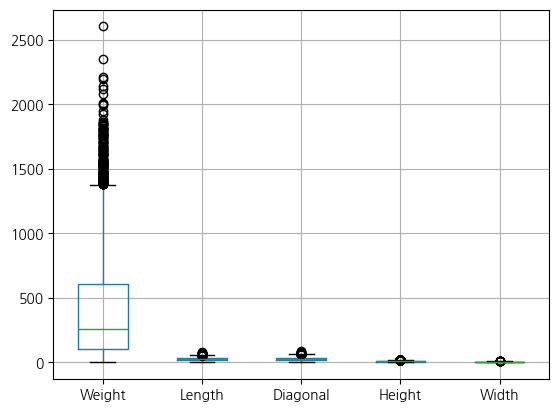

In [14]:
## 결측치 확인 ===> 없음
trainDF.isna().sum()

## 이상차 확인 ==> 모든 컬럼이 있음
trainDF.boxplot()
plt.show()

# trainDF.columns

In [ ]:
## 이상치 처리 (iqr을 통한 이상치 처리)

for col in trainDF.columns[:-1]:
    # Q1(25%), Q3(75%) 구하기
    Q1 = trainDF[col].quantile(0.25)
    Q3 = trainDF[col].quantile(0.75)
    IQR = Q3 - Q1

    # IQR 기반 하한/상한 구하기
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"=== {col} 처리 ===")
    print(f"Q1 = {Q1:.3f}, Q3 = {Q3:.3f}, IQR = {IQR:.3f}")
    print(f"lower = {lower_bound:.3f}, upper = {upper_bound:.3f}")

    # 이상치 대신 boundary 값으로 clipping
    trainDF[col] = trainDF[col].clip(lower=lower_bound, upper=upper_bound)

print("이상치 처리 완료")

## 확인
trainDF.boxplot()
plt.show()


In [16]:
## 상관관계를 보기위한 Species 숫자 매핑
display(trainDF['Species'].unique())
mapping = {
    'Bream': 0,
    'Roach': 1,
    'Whitefish': 2,
    'Parkki': 3,
    'Perch': 4,
    'Pike': 5,
    'Smelt': 6
}

trainDF['label'] = trainDF['Species'].map(mapping)
display(trainDF['label'].unique())
trainDF.head()

## 상관관계 확인
corr = trainDF.corr(numeric_only=True)
display(corr)


array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

array([0, 1, 2, 3, 4, 5, 6])

,Weight,Length,Diagonal,Height,Width,label
Weight,1.000000,0.910209,0.911204,0.654831,0.847653,-0.144505
Length,0.910209,1.000000,0.996706,0.617080,0.865005,-0.126323
Diagonal,0.911204,0.996706,1.000000,0.665658,0.876708,-0.189922
Height,0.654831,0.617080,0.665658,1.000000,0.814584,-0.693297
Width,0.847653,0.865005,0.876708,0.814584,1.000000,-0.418968
label,-0.144505,-0.126323,-0.189922,-0.693297,-0.418968,1.000000


In [17]:
## 피쳐 컬럼, 타겟컬럼 선택
## label과 가장 상관관계가 높은것은 height, width ==> 피쳐 컬럼 선택
## height, width
featureDF = trainDF.iloc[:,:-2]
# featureDF = trainDF.iloc[:, [3,4]]
# featureDF.head()


## testDF 피쳐 선택
# test_featureDF = testDF.iloc[:,[3,4]]
test_featureDF = testDF.iloc[:,:-1]


## Species
targetSR = trainDF.iloc[:,-2]
# targetSR.head()
test_targetSR = testDF.iloc[:,-1]

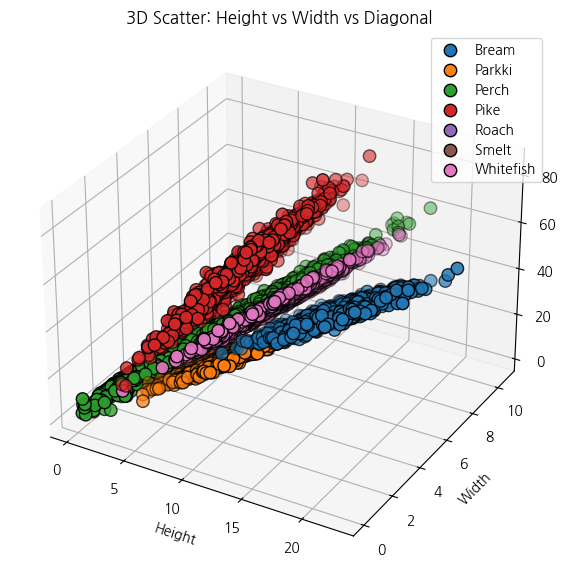

In [18]:
from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# 3D figure 생성
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Species 그룹별로 3D scatter 찍기
for name, group in trainDF.groupby('Species'):
    ax.scatter(
        group['Height'],        # X축
        group['Width'],         # Y축
        group['Diagonal'],      # Z축
        label=name,
        s=80,
        edgecolors='k'
    )

# 축 라벨링
ax.set_xlabel("Height")
ax.set_ylabel("Width")
ax.set_zlabel("Diagonal")

# 제목, 범례, 그리드
ax.set_title("3D Scatter: Height vs Width vs Diagonal")
ax.legend()
ax.grid(True)

plt.show()


In [19]:
## 스케일링
scaler = StandardScaler()

# fit + transform
scaled_features = scaler.fit_transform(featureDF)

test_scaled_feature = scaler.transform(test_featureDF)

print(scaled_features[:5])  

[[0.29437478 0.42314759 0.60711783 1.5444734  0.65135636]
 [1.70523903 1.19053668 1.36337754 2.57132704 1.64685539]
 [0.68573427 0.51076914 0.69375678 1.76147615 0.8811781 ]
 [1.02845383 0.7031595  0.86072106 1.88856023 1.09213339]
 [0.65362099 0.51789674 0.69898292 1.77114941 0.77347371]]


,n_neighbors,test_score,train_scores,diff
15,16,0.947238,0.954119,0.006881
13,14,0.949810,0.956833,0.007024
17,18,0.944000,0.951214,0.007214
11,12,0.952667,0.959952,0.007286
18,19,0.940762,0.948119,0.007357
16,17,0.943143,0.950667,0.007524
19,20,0.941429,0.949071,0.007643
10,11,0.951238,0.959119,0.007881
14,15,0.945143,0.953024,0.007881
9,10,0.954857,0.962857,0.008000


k 리스트: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
테스트 평균 점수: [np.float64(0.9586666666666666), np.float64(0.955904761904762), np.float64(0.9548571428571428), np.float64(0.9593333333333334), np.float64(0.9551428571428572), np.float64(0.9576190476190476), np.float64(0.9544761904761906), np.float64(0.9561904761904761), np.float64(0.9530476190476189), np.float64(0.9548571428571428), np.float64(0.9512380952380953), np.float64(0.9526666666666668), np.float64(0.9476190476190476), np.float64(0.9498095238095239), np.float64(0.9451428571428572), np.float64(0.9472380952380952), np.float64(0.9431428571428573), np.float64(0.944), np.float64(0.9407619047619047), np.float64(0.9414285714285713)]
트레인 평균 점수: [np.float64(1.0), np.float64(0.9878809523809524), np.float64(0.9789285714285715), np.float64(0.9773809523809524), np.float64(0.9704285714285714), np.float64(0.9710000000000001), np.float64(0.9658333333333333), np.float64(0.9672619047619048), np.float64(0.9625952380952381)

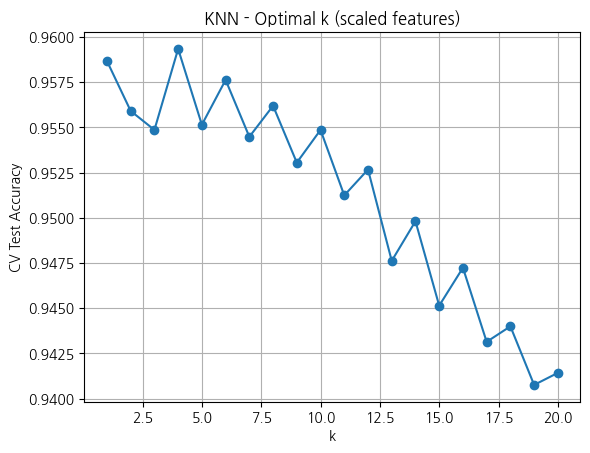

In [20]:
## 최적 k 찾기
X = scaled_features
y = targetSR.values      

k_list = range(1, 21) 
test_scores = []
train_scores = []
diff_list = []

for k in k_list:
    model = KNeighborsClassifier(n_neighbors=k)
    
    cv_result = cross_validate(
        model,
        X, y,
        cv=5,
        return_train_score=True
    )
    # print(cv_result)
    
    test_scores.append(cv_result['test_score'].mean())
    train_scores.append(cv_result['train_score'].mean())
    diff_list.append(abs(cv_result['test_score'].mean() - cv_result['train_score'].mean()))

totalDF = pd.DataFrame({
    'n_neighbors' : k_list,
    'test_score' : test_scores,
    'train_scores' : train_scores,
    'diff' : diff_list   
})
order_totalDF = totalDF.sort_values('diff', ascending=True)
display(order_totalDF)

print("k 리스트:", list(k_list))
print("테스트 평균 점수:", test_scores)
print("트레인 평균 점수:", train_scores)

best_k = k_list[np.argmax(test_scores)]
best_score = max(test_scores)

print("최적 k =", best_k)
print("해당 k에서의 평균 정확도 =", best_score)


plt.plot(list(k_list), test_scores, marker='o')
plt.xlabel("k")
plt.ylabel("CV Test Accuracy")
plt.title("KNN - Optimal k (scaled features)")
plt.grid(True)
plt.show()


In [24]:
## 최적 k를 이용한 테스트
## 범위를 21로 줄이면 최적 k는 17이 나옴
## 하지만 범위를 제곱근값인 100으로 하면 47이 나옴....

final_k = 6

## 모델 인스턴스 생성
final_model = KNeighborsClassifier(n_neighbors=final_k)

## 학습 진행
final_model.fit(scaled_features, targetSR)

## 평가
final_score = final_model.score(test_scaled_feature, test_targetSR)
print(final_score)


0.98
